In [23]:
library(CellChat)
library(patchwork)
options(stringsAsFactors = FALSE)
library(Seurat)

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following object is masked from ‘package:Seurat’:

    components


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [68]:
spatial <- readRDS('/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T2/bin50_seurat.rds')
DefaultAssay(spatial) <- 'RNA'
spatial <- NormalizeData(spatial)

Normalizing layer: counts



In [69]:
RCTD <- readRDS('/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T2/RCTD_results_doublet.rds')
spatial <- AddMetaData(spatial, metadata = RCTD@results$results_df)

In [70]:
spatial@meta.data$first_type <- as.vector(spatial@meta.data$first_type)

In [71]:
spatial@meta.data$first_type <- paste0('ST_',spatial@meta.data$first_type)

In [72]:
spatial

An object of class Seurat 
38658 features across 35334 samples within 2 assays 
Active assay: RNA (19329 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: SCT
 2 dimensional reductions calculated: pca, umap

In [73]:
spatial <- subset(spatial,spot_class != 'reject')

In [74]:
spatial_macrophage <- readRDS('/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/spatial_macrophage.rds')
spatial_macrophage_T2 <- subset(spatial_macrophage,time=='T2')
spatial_macrophage_T2

An object of class Seurat 
36126 features across 1980 samples within 2 assays 
Active assay: SCT (15962 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [75]:
spatial@meta.data[gsub('T2_','',rownames(spatial_macrophage_T2@meta.data)),'first_type'] <- gsub('-','_',spatial_macrophage_T2@meta.data$celltype)

In [76]:
table(spatial@meta.data$first_type)


    Macro_Apoe    Macro_Ccl24     Macro_Cd44      Macro_Mt1           ST_1 
          1125             81            263            511           1412 
          ST_2           ST_3           ST_4           ST_5          ST_DC 
         10526          13164            366           1444            357 
ST_endothelial  ST_Fibroblast    ST_Monocyte  ST_Neutrophil          ST_NK 
           210           3463            470              4              4 
     ST_T_cell 
            10 

In [26]:
write.table(spatial@meta.data,file='/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T2/spacia_metadata.sub.txt',quote=F,col.names = NA,sep=',')

In [77]:
spatial <- subset(spatial,first_type %in% c('Macro_Apoe','Macro_Mt1','ST_1','ST_2','ST_3'))

In [78]:
table(spatial@meta.data$first_type)


Macro_Apoe  Macro_Mt1       ST_1       ST_2       ST_3 
      1125        511       1412      10526      13164 

In [79]:
spatial.locs <- spatial@meta.data[,c('x','y')]
spatial.factors <- list(spot.diameter = 25, spot = 50,ratio = 0.5,tol=12.5)
cellchat <- createCellChat(object = spatial, group.by = "first_type", assay = "SCT",datatype = "spatial", coordinates = spatial.locs, spatial.factors = spatial.factors)

CellChatDB <- CellChatDB.mouse
CellChatDB.use <- subsetDB(CellChatDB)
cellchat@DB <- CellChatDB.use
cellchat <- subsetData(cellchat)

future::plan("multisession", workers = 1) # do parallel
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)
cellchat <- computeCommunProb(cellchat, type = "truncatedMean", trim = 0.05, 
                              distance.use = T, scale.distance = 200,contact.range = 200)#scale.distance = 200,
cellchat <- filterCommunication(cellchat, min.cells = 10)
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)
#saveRDS(cellchat, file = '/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/T2/cellchat.rds')

[1] "Create a CellChat object from a Seurat object"
The `meta.data` slot in the Seurat object is used as cell meta information 
Create a CellChat object from spatial transcriptomics data... 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Macro_Apoe, Macro_Mt1, ST_1, ST_2, ST_3 
The number of highly variable ligand-receptor pairs used for signaling inference is 717 
truncatedMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on spatial transcriptomics data using distances as constraints of the computed communication probability <<< [2025-04-22 09:45:38.762114]"
The input L-R pairs have both secreted signaling and contact-dependent signaling. Run CellChat in a contact-dependent manner for `Cell-Cell Contact` signaling, and in a diffusion manner based on the `interaction.range` for other L-R pairs. 
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<

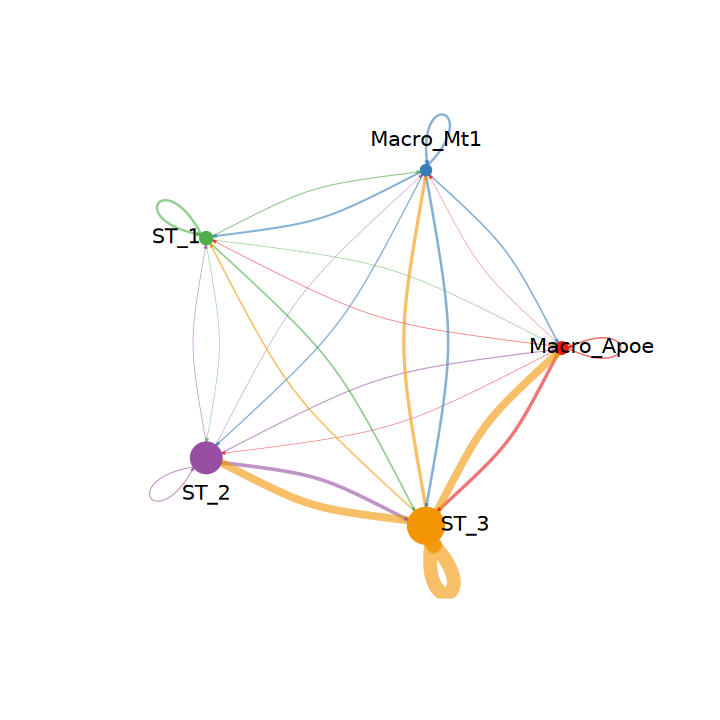

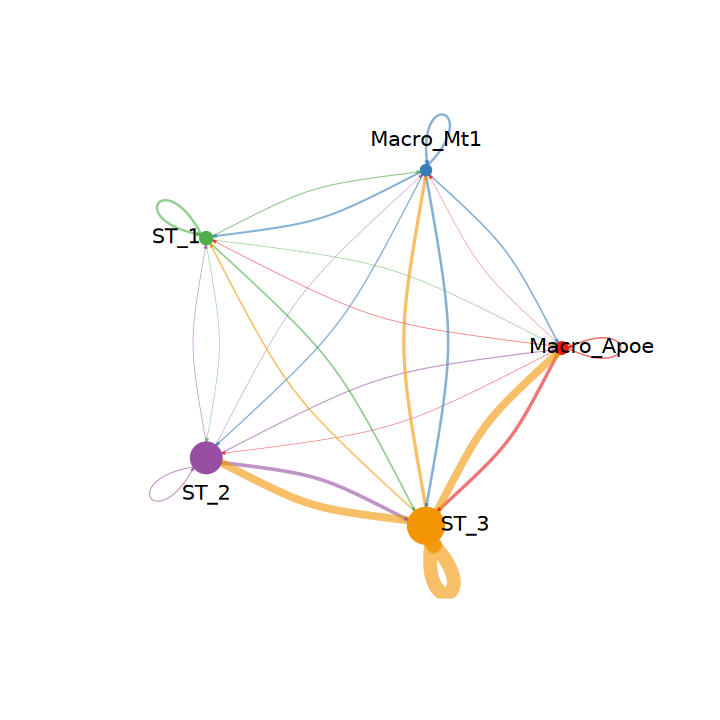

In [80]:
options(repr.plot.width=6, repr.plot.height=6)
groupSize <- as.numeric(table(cellchat@idents))
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

Comparing communications on a single object 




$communication
    source     target      ligand     receptor       prob pval
241   ST_3  Macro_Mt1        Agrn         Dag1 0.06544780    3
71    ST_3 Macro_Apoe      Angpt2  ITGA5_ITGB1 0.05076402    3
72    ST_3  Macro_Mt1      Angpt2  ITGA5_ITGB1 0.04937210    3
63    ST_3  Macro_Mt1     Angptl2  ITGA5_ITGB1 0.07122519    2
64    ST_2 Macro_Apoe     Angptl2         Pirb 0.06895504    2
65    ST_3 Macro_Apoe     Angptl2         Pirb 0.06791433    3
66    ST_2  Macro_Mt1     Angptl4  ITGA5_ITGB1 0.06284026    2
67    ST_3  Macro_Mt1     Angptl4  ITGA5_ITGB1 0.06314196    2
68    ST_2 Macro_Apoe     Angptl4         Sdc1 0.07347750    3
69    ST_3 Macro_Apoe     Angptl4         Sdc1 0.07208836    3
70    ST_3 Macro_Apoe     Angptl4         Sdc4 0.06919586    2
302   ST_3 Macro_Apoe        Apoe TREM2_TYROBP 0.08447568    3
252   ST_3 Macro_Apoe         App         Cd74 0.08532930    3
253   ST_3  Macro_Mt1         App         Cd74 0.07949168    3
301   ST_3 Macro_Apoe         App TREM2_

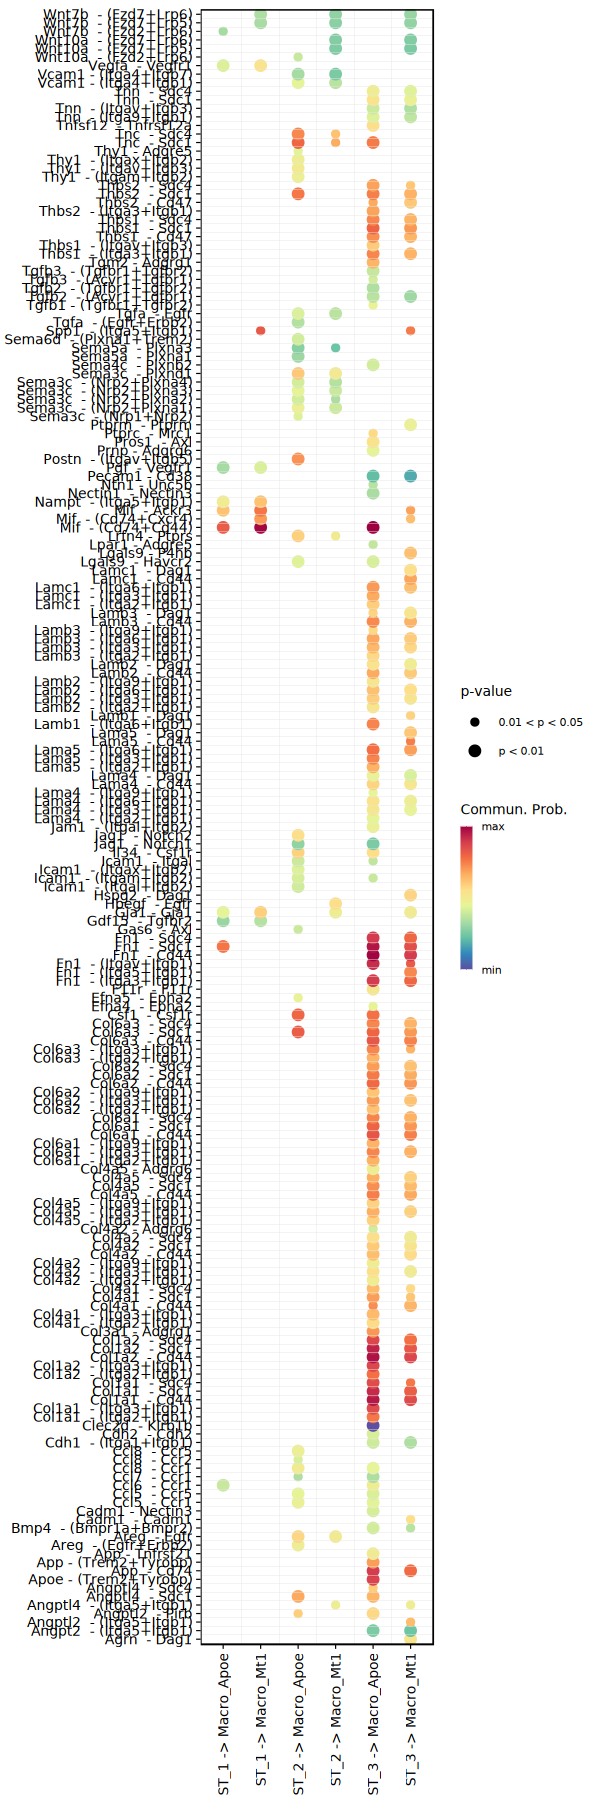

In [81]:
options(repr.plot.width=5, repr.plot.height=15)
plot <- netVisual_bubble(cellchat, sources.use = c('ST_1','ST_2','ST_3'), targets.use = c('Macro_Apoe','Macro_Mt1'),return.data = T)
print(plot)

In [36]:
write.table(plot$communication,file='/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/communication/T2_tumor_to_macro.csv',sep=',',col.names=NA,quote=F)

Comparing communications on a single object 




$communication
        source target      ligand     receptor       prob pval
171 Macro_Apoe   ST_3 ITGAV_ITGB1       Adgre5 0.06788698    3
169 Macro_Apoe   ST_2 ITGAV_ITGB3       Adgra2 0.05526458    3
170  Macro_Mt1   ST_2 ITGAV_ITGB3       Adgra2 0.05178118    3
142 Macro_Apoe   ST_3        Agrn         Dag1 0.06864751    3
83  Macro_Apoe   ST_3     Angptl2         Pirb 0.06714222    3
85  Macro_Apoe   ST_3     Angptl4        Cdh11 0.05810979    2
84  Macro_Apoe   ST_3     Angptl4         Cdh5 0.05049270    3
182 Macro_Apoe   ST_3        Apoe TREM2_TYROBP 0.08424287    3
183  Macro_Mt1   ST_3        Apoe TREM2_TYROBP 0.07891298    3
146  Macro_Mt1   ST_3         App         Cd74 0.07962923    2
180 Macro_Apoe   ST_3         App TREM2_TYROBP 0.07400947    3
181  Macro_Mt1   ST_3         App TREM2_TYROBP 0.07032504    3
176 Macro_Apoe   ST_3         App        Sorl1 0.06070875    3
177  Macro_Mt1   ST_3         App        Sorl1 0.05821019    3
178 Macro_Apoe   ST_2         App     Tn

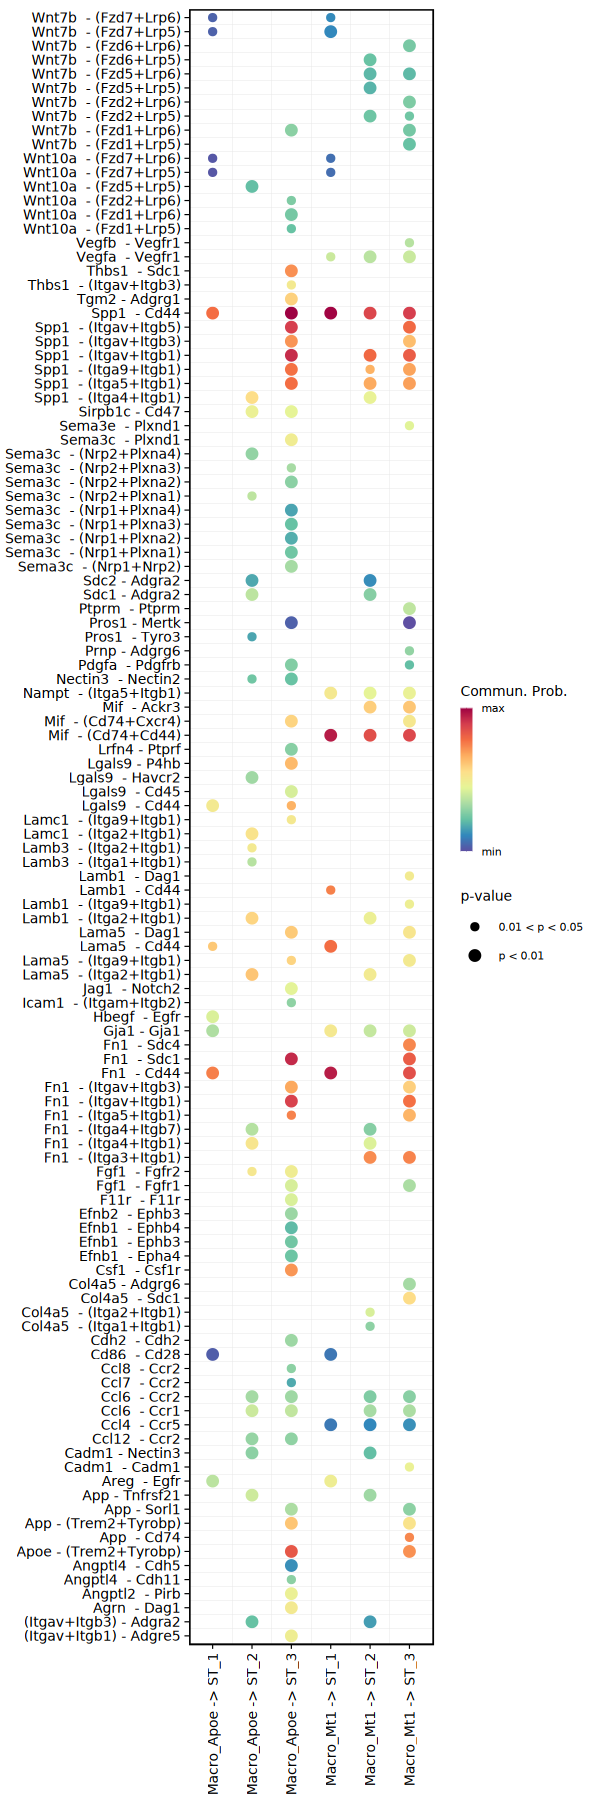

In [59]:
options(repr.plot.width=5, repr.plot.height=15)
plot <- netVisual_bubble(cellchat, targets.use = c('ST_1','ST_2','ST_3'), sources.use = c('Macro_Apoe','Macro_Mt1'),return.data = T)
print(plot)

In [60]:
write.table(plot$communication,file='/syn1/liangzhen/jinhua_jilab_project/result/SPATIAL/communication/T2_macro_to_tumor.csv',sep=',',col.names=NA,quote=F)